# get signal

In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt
from trader import get_klines
from trader import klines_to_dfmpl
%matplotlib inline
from collections import Counter
import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests
config = json.load(open("secrets.config","r")) 
role="<@&1126499478342475807>"

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

def mapped(i):
    if i[:2]=="00":
        return -1
    if i[:2]=="11":
        return 1
    return 0
def now_ms():
    return int(time.time()*1_000)

# define constants
tickerpair="ETCUSDT"
interval="5m"
percentile=98
#thres_diff=0.004225 #ETCUSDT 30m 98%
#thres_diff=0.002227 #ETCUSDT 15m 98%
thres_diff=0.0009295 *0.95 #ETCUSDT 5m 98%
entered=False


In [2]:
def get_signal():
    global new_entry, entered,thres_diff,percentile,interval,tickerpair
    klines = get_klines(tickerpair,interval,limit=500)
    dfmpl = klines_to_dfmpl(klines).iloc[:-1]
    #fulllen=len(dfmpl)
    #print(fulllen)

    xvals=np.arange(len(dfmpl.Close))
    rolling_high_std_mean = dfmpl.High.rolling(14).std()/dfmpl.High.rolling(14).mean()
    rolling_low_std_mean = dfmpl.Low.rolling(14).std()/dfmpl.Low.rolling(14).mean()
    rolling_std_mean=rolling_low_std_mean*0.5+rolling_high_std_mean*0.5
    r_std_mean_diff = rolling_std_mean.diff()

    if not thres_diff:
        thres_diff = np.percentile(r_std_mean_diff.values[np.where(~np.isnan(r_std_mean_diff.values))],percentile)

    mkoffset = 1.01
    crossings = np.where(np.diff(r_std_mean_diff>thres_diff,1))[0]
    scatter = [ dfmpl.Close.iloc[i]*mkoffset if i in crossings else np.nan for i in xvals]
    crossup=np.where(np.diff((r_std_mean_diff>thres_diff)*1.,1)>0)[0]
    scatterup = [ dfmpl.Close.iloc[i]*mkoffset if i in crossup else np.nan for i in xvals]
    crossdn=np.where(np.diff((r_std_mean_diff>thres_diff)*1.,1)<0)[0]
    scatterdn = [ dfmpl.Close.iloc[i]*mkoffset if i in crossdn else np.nan for i in xvals] 

    entrys = np.where(~np.isnan(scatterup))[0]
    exits = np.where(~np.isnan(scatterdn))[0]
    #get all entry signal
    entry_signals = []
    for entry in entrys:
        if (entry-2)<0:
            continue
        s_1 = dfmpl.iloc[entry-2]
        s = dfmpl.iloc[entry-1]
        s1 = dfmpl.iloc[entry] 
        values_ = [s_1.Close-s_1.Open,s.Close-s.Open]
        presignal = "".join([ "1"if x>0 else "0" for x in values_])
        buy=mapped(presignal)
        if buy!=0:
            entry_signals.append( (entry,buy) )
    # check if its new entry
    new_entry=False
    entry_df= None;entry_time_utc_ms=None;buy=None
    for entry,exit in zip_longest(entrys,exits,fillvalue=None):
        if exit is None: # missing exit signal, so its a new enter signal
            buy_list = [ buy for entry_, buy in entry_signals if entry_==entry]
            if len(buy_list)==1: 
                new_entry=True
                entry_df=dfmpl.iloc[entry]
                buy=buy_list[0]

    if new_entry and entered:
        #print(dfmpl.iloc[-1])
        #print("hold")
        pass
    elif not new_entry and entered:
        #print(dfmpl.iloc[exits[-1]])
        #print("exit trade now")
        entered=False
        requests.post(config["crypto-signals2"],data={"content":f"exit {tickerpair} {interval} {dfmpl.iloc[-1].Close}"})
    elif new_entry and not entered:
        entry_time_utc_ms = entry_df.name.value//1_000_000
        xx = entry_df.Close
        strr = tickerpair+" "+ ("BUY  " if buy==1 else "SELL ")+f"{xx}" 
        strr += f" tp {xx*(1+0.01*buy):.4f} sl {xx*(1-0.005*buy):.4f}\n"
        strr += f"{entry_df.name} {role} at {str(datetime.datetime.now())}"
        #print(strr)
        requests.post(config["crypto-signals2"],data={"content":strr})
        #print(entry_df)
        entered=True
        #print("*"*8,"new entry",entry_time_utc_ms) #klinetime= entry_time_utc_ms-3*3600*1_000
    else:
        strr = f"fetched {tickerpair} {interval} at {dfmpl.iloc[-1].name} at {str(datetime.datetime.now())}"
        requests.post(config["status-ping2"],data={"content":strr})

In [3]:
#time.sleep(60*2)
schedule.every(5).minutes.at(":03").do(get_signal) # run this at 22:30:04
#time.sleep((4-datetime.datetime.now().minute%5)*60)
while True:
    schedule.run_pending()
    time.sleep(1)

ReadTimeout: HTTPSConnectionPool(host='api.binance.com', port=443): Read timed out. (read timeout=None)

# end of file

In [67]:
entrys[-1],dfmpl.iloc[entrys[-1]].name,dfmpl.iloc[entrys[-1]].Close,exits[-1],dfmpl.iloc[exits[-1]].name,dfmpl.iloc[exits[-1]].Close

(497,
 Timestamp('2023-07-06 08:20:00'),
 19.37,
 502,
 Timestamp('2023-07-06 08:45:00'),
 19.62)

In [68]:
dfmpl.iloc[-10:]

,Open,High,Low,Close,Volume
Date,,,,,
2023-07-06 08:05:00,19.15,19.16,19.13,19.13,625.65
2023-07-06 08:10:00,19.12,19.27,19.12,19.25,3540.77
2023-07-06 08:15:00,19.24,19.33,19.24,19.28,2274.46
2023-07-06 08:20:00,19.28,19.37,19.28,19.37,2634.71
2023-07-06 08:25:00,19.37,19.46,19.36,19.43,8511.97
2023-07-06 08:30:00,19.44,19.50,19.39,19.44,9974.52
2023-07-06 08:35:00,19.45,19.77,19.45,19.75,32134.99
2023-07-06 08:40:00,19.75,19.88,19.70,19.81,24537.88
2023-07-06 08:45:00,19.81,19.81,19.61,19.62,13658.81


In [69]:
dfmpl.iloc[-10:]

,Open,High,Low,Close,Volume
Date,,,,,
2023-07-06 08:05:00,19.15,19.16,19.13,19.13,625.65
2023-07-06 08:10:00,19.12,19.27,19.12,19.25,3540.77
2023-07-06 08:15:00,19.24,19.33,19.24,19.28,2274.46
2023-07-06 08:20:00,19.28,19.37,19.28,19.37,2634.71
2023-07-06 08:25:00,19.37,19.46,19.36,19.43,8511.97
2023-07-06 08:30:00,19.44,19.50,19.39,19.44,9974.52
2023-07-06 08:35:00,19.45,19.77,19.45,19.75,32134.99
2023-07-06 08:40:00,19.75,19.88,19.70,19.81,24537.88
2023-07-06 08:45:00,19.81,19.81,19.61,19.62,13658.81


In [60]:
%%time
predict = [] # capture data
result= [] 
entry_exit_pairs=(entrys,exits)
for entry,exit in zip(*entry_exit_pairs):
    if (entry-2)<0:
        continue
    s_1 = dfmpl.iloc[entry-2]
    s = dfmpl.iloc[entry-1]
    s1 = dfmpl.iloc[entry]
    s2 = dfmpl.iloc[exit]
    predict.append( (s_1.Close-s_1.Open,s.Close-s.Open) )
    result.append( s2.Close-s.Close )
pred_sign = np.sign(predict,out=np.ones_like(np.asarray(predict))*-1.,where=np.asarray(predict)!=0)
true_sign = np.sign(result,out=np.ones_like(np.asarray(result))*-1.,where=np.asarray(result)!=0)

CPU times: total: 0 ns
Wall time: 1.99 ms


In [61]:
input_labels = [ "".join([ "1"if x>0 else "0" for x in [*i,z]]) for i,z in zip(pred_sign,true_sign) ] 
predict_seq = sorted(Counter(input_labels).items()) 

In [12]:
predicted_result = np.asarray([ mapped(i) for i in input_labels])

In [13]:
lastNsamples = int(len(result)*0.1)
print("total results=",len(result) ,"lastN",lastNsamples) 

total results= 9 lastN 0


In [14]:
%%time
profit=[] # implement backtesting for this strat
trade_durations = []
concated_df0=[]
concated_df0_signal=[]
high_low_pair = []
for entry,exit,buy in zip(*entry_exit_pairs,predicted_result): 
    s_1 = dfmpl.iloc[entry-2]
    s = dfmpl.iloc[entry-1]
    s1 = dfmpl.iloc[entry]
    s2 = dfmpl.iloc[exit]
    if buy==0:continue #if buy==-1:continue
    gains= buy*(s2.Close-s.Close)/(s.Close)
    profit.append(gains)
    # collecting trade stats
    indd=dfmpl.iloc[[entry,exit]].index
    diff = indd[1].to_datetime64()-indd[0].to_datetime64()
    trade_hr = int(diff)*1e-9/3600
    trade_durations.append( trade_hr )
    concated_df0.append( dfmpl.iloc[entry-1:exit+1] )
    concated_df0_signal.append(buy)
    high_low_pair.append( (s.Close,s2.Close,buy,
                           dfmpl.iloc[entry:exit+1].High.max(),
                           dfmpl.iloc[entry:exit+1].Low.min()) )  

CPU times: total: 15.6 ms
Wall time: 17 ms


In [15]:
len(pred_sign),len(predict),len(result)

(9, 9, 9)

In [16]:
def get_stats(lastNsamples=0):
    final_profit = 1
    profit1=profit[-lastNsamples:]
    ind=dfmpl.iloc[np.where(~np.isnan(scatterup))[0][np.r_[-lastNsamples,-1]]].index
    equity=[1]
    for p in profit1:
        final_profit *= (1+p)
        equity.append(final_profit)
    wins=sum(p>0 for p in profit1)
    diff = ind[1].to_datetime64()-ind[0].to_datetime64()
    trading_days = max(int(diff)*1e-9/3600/24,1)
    gains_=final_profit*100-100
    print(final_profit,trading_days)
    gains_per_day = np.exp(np.log(final_profit)/trading_days)*100-100
    gains_per_trade = np.exp(np.log(final_profit)/len(profit1))*100-100
    str1=f"gain% = {gains_:.2f}%"+f", avg%= {np.mean(profit1)*100:.2f}%"+"\n"+\
          f"trades={len(profit1)}, wins={wins}, win%={wins/len(profit1)*100:.2f}%"+"\n"+\
          f"days={trading_days:.3g}d, trade dur={np.mean(trade_durations[-lastNsamples:]):.3g}hr"+"\n"+\
    f"g%/day={gains_per_day:.2f}%/d, g%/trade={gains_per_trade:.2f}%/trd"
    return str1,gains_,trading_days
final_profit = 1
profit1=profit
equity=[1]
for p in profit1:
    final_profit *= (1+p)
    equity.append(final_profit)

1.0585607780903592 3.2916666666666665
1.0585607780903592 3.2916666666666665


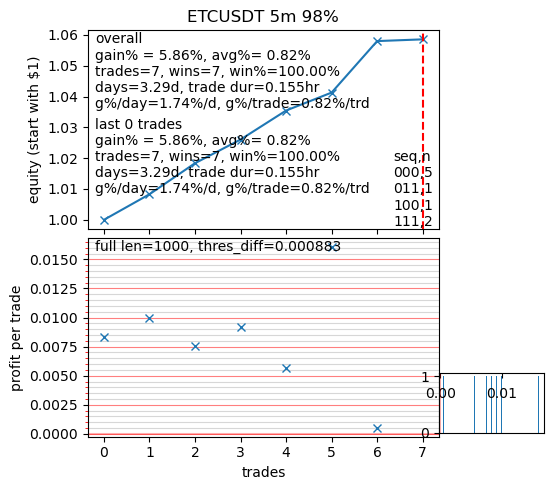

In [17]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(6,5),sharex=True)
ax1.plot(equity,"-x")
ax1.set_ylabel("equity (start with $1)")
ax1.set_title(f"{tickerpair} {interval} {percentile}%")
str1,gains__,trading_days = get_stats(0)
ax1.text(0.02,0.99, "overall\n"+str1,transform=ax1.transAxes,va="top",ha="left")
ax1.text(0.02,0.56, f"last {lastNsamples} trades\n"+get_stats(lastNsamples)[0],transform=ax1.transAxes,va="top",ha="left")
ax1.text(0.87,0.0, "seq,n\n"+"\n".join([p[0]+","+str(p[1]) for p in predict_seq]),transform=ax1.transAxes,va="bottom",ha="left")
ax1.axvline(len(profit)-lastNsamples,c="r",ls="--")
ax2.plot(profit,"x")
ax2.axhline(0,c="r",alpha=0.3)
ax2.set_ylabel("profit per trade")
#ax2.text(0.02,0.99,f"full len={fulllen}, thres_diff={thres_diff:.4g}",transform=ax2.transAxes,va="top",ha="left")
ax2.text(0.02,0.99,f"thres_diff={thres_diff:.4g}",transform=ax2.transAxes,va="top",ha="left")
for ax in (ax1,ax2):
    ax.set_xlabel("trades")
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params("y",which='minor',color="r")
ax2.grid(which='minor',axis="y",alpha=0.5)
ax2.grid(which='major',axis="y",color="r",alpha=0.5)
plt.tight_layout()
ax3 = ax2.inset_axes((1,0.02,0.3,0.3))

ax3.hist(profit,bins=100)
ax3.axvline(0,c="r",alpha=0.3)
ax3.tick_params("x",top=True, labeltop=True, bottom=False, labelbottom=False,pad=-20,direction="in") 

plt.tight_layout(h_pad=-1.08)

<timed exec>:6: UserWarning: FixedFormatter should only be used together with FixedLocator


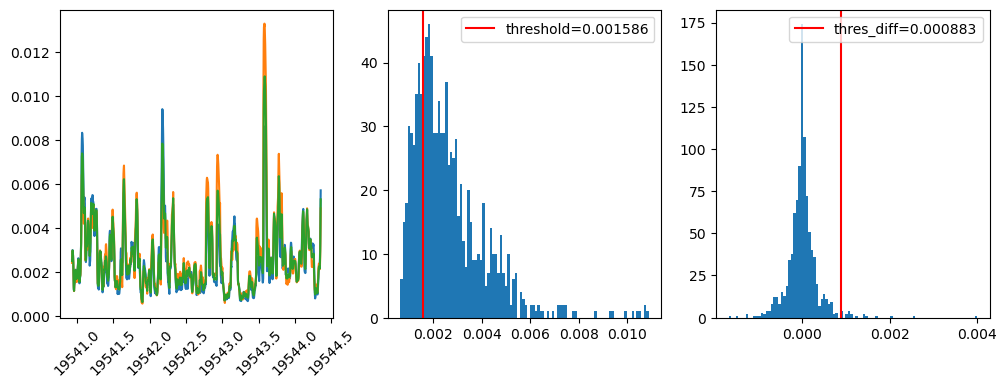

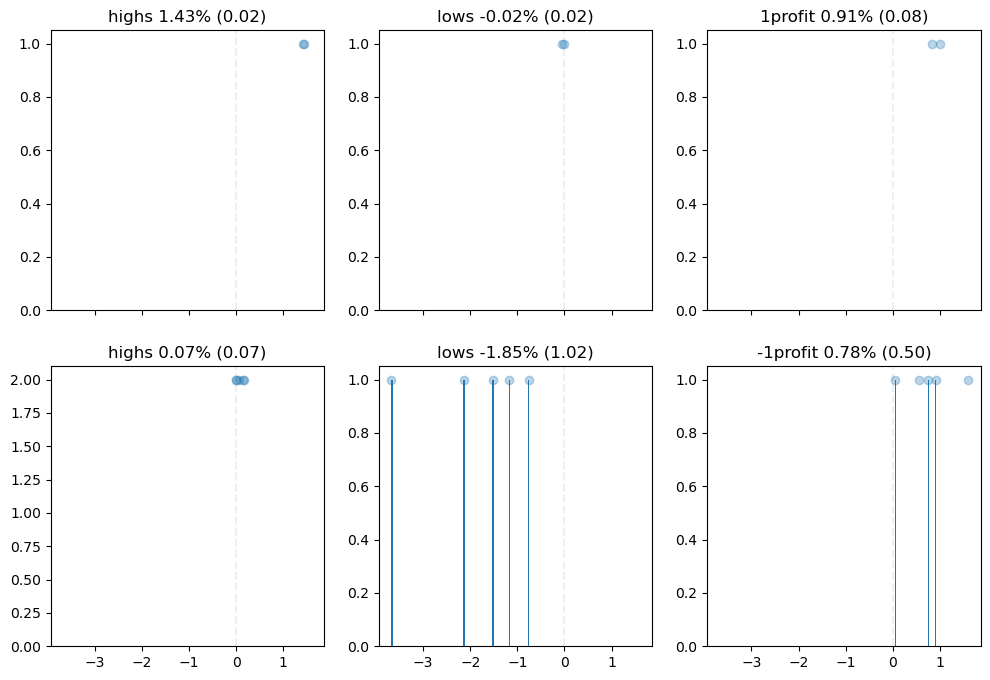

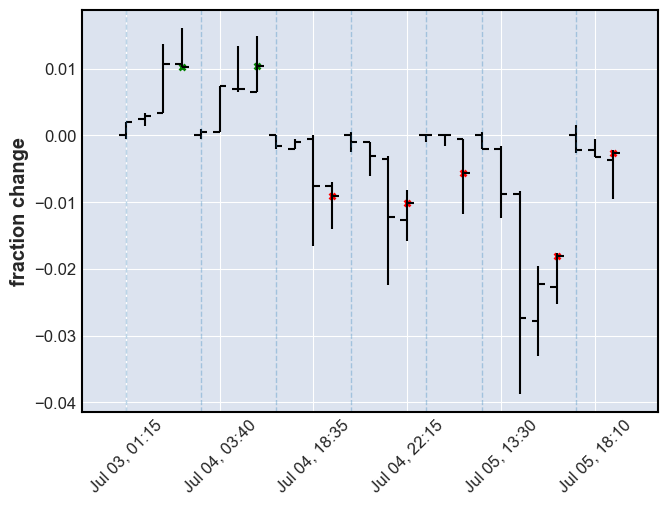

CPU times: total: 2.75 s
Wall time: 3.34 s


In [18]:
%%time
if True:
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
    ax1.plot(rolling_high_std_mean)
    ax1.plot(rolling_low_std_mean)
    ax1.plot(rolling_std_mean)
    ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
    n,bins,_ = ax2.hist(rolling_std_mean,bins=100)
    thres = np.percentile(rolling_std_mean.values[np.where(~np.isnan(rolling_std_mean.values))],25)
    ax2.axvline(thres,c="r",label=f"threshold={thres:.4g}")
    ax2.legend()
    ax3.hist(r_std_mean_diff,bins=100)
    ax3.axvline(thres_diff,c="r",label=f"thres_diff={thres_diff:.4g}")
    ax3.legend()
    plt.show()
if True:
    fig,axxx=plt.subplots(2,3,figsize=(12,8),sharex=True)
    for buy_,axx in zip([1,-1],axxx):
        highs=[(high-ent)/ent*100 for ent,exi,buy,high,low in high_low_pair if buy==buy_]
        lows=[(low-ent)/ent*100 for ent,exi,buy,high,low in high_low_pair if buy==buy_]
        profit_=[buy*(exi-ent)/ent*100 for ent,exi,buy,high,low in high_low_pair if buy==buy_]

        ax=axx[0]
        n,bins,_ = ax.hist(highs,bins=100);
        ax.scatter(highs,[np.max(n)]*len(highs),alpha=0.3)
        ax.set_title(f"highs {np.mean(highs):.2f}% ({np.std(highs):.2f})")
        ax=axx[1]
        n,bins,_ = ax.hist(lows,bins=100);
        ax.scatter(lows,[np.max(n)]*len(lows),alpha=0.3)
        ax.set_title(f"lows {np.mean(lows):.2f}% ({np.std(lows):.2f})")
        ax=axx[2]
        n,bins,_ = ax.hist(profit_,bins=100);
        ax.scatter(profit_,[np.max(n)]*len(profit_),alpha=0.3)
        ax.set_title(f"{buy_}profit {np.mean(profit_):.2f}% ({np.std(profit_):.2f})")
        for ax in axx:
            ax.axvline(0,ls="--",alpha=0.1)
    plt.show()
        
if True:
    concated_df = pd.concat([(i-i.iloc[0].Open)/i.iloc[0].Open for i in concated_df0[:20]])
    l_ = 0
    scatter_=[]
    scatter_color_up=[]
    scatter_color_dn=[]
    my_vlines = [ ]
    for i,buy in zip(concated_df0[:20],concated_df0_signal):
        my_vlines.append(l_)
        for ii in range(len(i)):
            l_ +=1
            scatter_.append(np.nan)
            scatter_color_up.append(np.nan)
            scatter_color_dn.append(np.nan)
        scatter_.pop()
        scatter_.append(concated_df.iloc[l_-1].Close)
        if buy>0:
            scatter_color_up.pop()
            scatter_color_up.append(concated_df.iloc[l_-1].Close)
        else:
            scatter_color_dn.pop()
            scatter_color_dn.append(concated_df.iloc[l_-1].Close)
    apds = [ 
        #mpf.make_addplot(rolling_std_mean,panel=1,color='b',type='line',ylabel=f"diff(std/mean)>thres{thres_diff:.2g}"), 
       #mpf.make_addplot(scatterup,color='g',type='scatter',marker="^"),
       #mpf.make_addplot(scatter_,color='r',type='scatter',marker="x"),
        mpf.make_addplot(scatter_color_up,color='g',type='scatter',marker="x",secondary_y=False),
        mpf.make_addplot(scatter_color_dn,color='r',type='scatter',marker="x",secondary_y=False),
           ]
    fig, axlist =mpf.plot(concated_df,addplot=apds, returnfig=True,ylabel="fraction change")
    for ax in axlist[:]:
        for vline in my_vlines:
            ax.axvline(x=vline, linestyle='--',linewidth=1,alpha=0.3)
    plt.show()